# Data Loading

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # specify GPUs locally
/
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
##train = pd.read_csv('../input/d/datasets/sriv2804/cyberlabav/train_DETg9GD/train.csv')
##test = pd.read_csv('../input/d/datasets/sriv2804/cyberlabav/test_Bh8pGW3/test.csv')


In [3]:
##train_casava = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

In [4]:
##train

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
data=pd.read_csv('../input/heckfestt/target_id_path')

In [7]:
data

,tar,id,path
0,5.0,20000943.0,/kaggle/input/heckfest/20000943.tif
1,3.0,10012150.0,/kaggle/input/heckfest/10012150.tif
2,2.0,10001662.0,/kaggle/input/heckfest/10001662.tif
3,3.0,10005404.0,/kaggle/input/heckfest/10005404.tif
4,4.0,20003286.0,/kaggle/input/heckfest/20003286.tif
...,...,...,...
3093,5.0,20005413.0,/kaggle/input/heckfest/20005413.tif
3094,5.0,20006668.0,/kaggle/input/heckfest/20006668.tif
3095,2.0,20002368.0,/kaggle/input/heckfest/20002368.tif
3096,4.0,20002195.0,/kaggle/input/heckfest/20002195.tif


In [8]:
data['tar'][0]

5.0

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
for i in range(len(data)):
    if(data['tar'][i]>3):
        data['tar'][i] =  0
    else:
        data['tar'][i] = 1

In [11]:
data['tar'].value_counts()

0.0    2355
1.0     743
Name: tar, dtype: int64

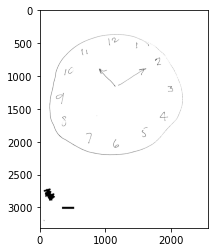

In [12]:
import cv2
from matplotlib import pyplot as plt
plt.imshow(cv2.imread(data['path'][0]))

In [13]:
train=data[:2900]
test=data[2901:]

In [14]:
# train.drop(['Unnamed: 0'],axis=1,inplace=True)
# test.drop(['Unnamed: 0'],axis=1,inplace=True)
train

,tar,id,path
0,0.0,20000943.0,/kaggle/input/heckfest/20000943.tif
1,1.0,10012150.0,/kaggle/input/heckfest/10012150.tif
2,1.0,10001662.0,/kaggle/input/heckfest/10001662.tif
3,1.0,10005404.0,/kaggle/input/heckfest/10005404.tif
4,0.0,20003286.0,/kaggle/input/heckfest/20003286.tif
...,...,...,...
2895,0.0,10000200.0,/kaggle/input/heckfest/10000200.tif
2896,0.0,20000959.0,/kaggle/input/heckfest/20000959.tif
2897,1.0,10011443.0,/kaggle/input/heckfest/10011443.tif
2898,0.0,10004066.0,/kaggle/input/heckfest/10004066.tif


# Directory settings

In [15]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = '../input/d/datasets/sriv2804/cyberlabav/train_DETg9GD/Train'
TEST_PATH = '../input/d/datasets/sriv2804/cyberlabav/test_Bh8pGW3/Test'

# CFG

In [16]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    print_freq=500
    num_workers=4
    model_name='efficientnet_b4'
    size=512
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    criterion='LabelSmoothing' # ['CrossEntropyLoss', LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    epochs=5
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    #T_max=10 # CosineAnnealingLR
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=10
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='tar'
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    smoothing=0.05
    t1=0.3 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    t2=1.0 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [17]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [18]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [19]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  tar
0     0.0    442
      1.0    138
1     0.0    442
      1.0    138
2     0.0    442
      1.0    138
3     0.0    441
      1.0    139
4     0.0    441
      1.0    139
dtype: int64


# Dataset

In [20]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.labels = df['tar'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['path'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = file_name
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

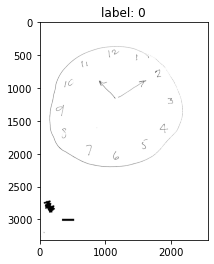

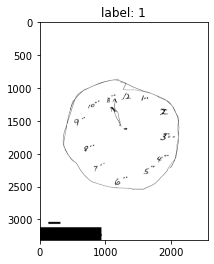

In [21]:
train_dataset = TrainDataset(train, transform=None)

for i in range(2):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [22]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
#             A.RandomResizedCrop(CFG.size, CFG.size),
            ##A.Transpose(p=0.5),
            ##A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5),
            #A.ColorJitter(),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

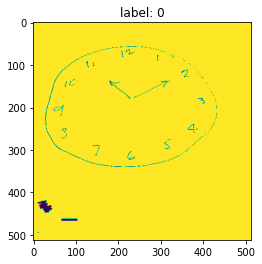

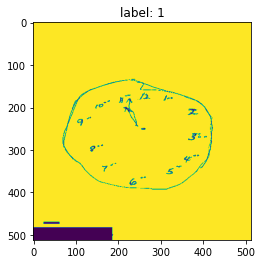

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(2):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [24]:
# ====================================================
# MODEL
# ====================================================
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    

class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=True)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

# for image, label in train_loader:
#     output = model(image)
#     print(output)
#     break

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth


# Criterion

## Label Smoothing

In [26]:
# ====================================================
# Label Smoothing
# ====================================================
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=2, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

## Focal Loss

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

# Helper functions

In [28]:
from tqdm import tqdm

In [29]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps       
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions



# Train loop

In [30]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model = CustomEfficientNet(CFG.model_name, pretrained=True)
    
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
       
        
    
    # ====================================================
    # Criterion - ['LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    # ====================================================
    
    def get_criterion():
        if CFG.criterion=='CrossEntropyLoss':
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion=='LabelSmoothing':
            criterion = LabelSmoothingLoss(classes=CFG.target_size, smoothing=CFG.smoothing)
        elif CFG.criterion=='FocalLoss':
            criterion = FocalLoss().to(device)
        return criterion


    # ====================================================
    # loop 
    # ====================================================
    criterion = get_criterion()
    LOGGER.info(f'Criterion: {criterion}')

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            print('YES')
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds,
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict()},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [31]:
# ====================================================
# main
# ====================================================
def main():
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train: 
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [32]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========
Criterion: LabelSmoothingLoss()
  0%|          | 1/232 [00:05<21:57,  5.70s/it]

Epoch: [1][0/232] Data 2.748 (2.748) Elapsed 0m 5s (remain 22m 23s) Loss: 0.6739(0.6739) Grad: 2.1483  


100%|██████████| 232/232 [03:03<00:00,  1.27it/s]

Epoch: [1][231/232] Data 0.001 (0.017) Elapsed 3m 3s (remain 0m 0s) Loss: 0.6634(0.5326) Grad: 1.9232  


EVAL: [0/58] Data 2.029 (2.029) Elapsed 0m 2s (remain 2m 4s) Loss: 0.5577(0.5577) 


Epoch 1 - avg_train_loss: 0.5326  avg_val_loss: 0.4523  time: 215s
Epoch 1 - Accuracy: 0.8344827586206897
Epoch 1 - Save Best Score: 0.8345 Model


EVAL: [57/58] Data 0.000 (0.397) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4583(0.4523) 
YES


  0%|          | 1/232 [00:03<12:17,  3.19s/it]

Epoch: [2][0/232] Data 2.205 (2.205) Elapsed 0m 3s (remain 12m 42s) Loss: 0.3192(0.3192) Grad: 1.4941  


100%|██████████| 232/232 [02:48<00:00,  1.37it/s]

Epoch: [2][231/232] Data 0.004 (0.015) Elapsed 2m 48s (remain 0m 0s) Loss: 0.3171(0.4054) Grad: 0.8224  


EVAL: [0/58] Data 2.230 (2.230) Elapsed 0m 2s (remain 2m 16s) Loss: 0.5137(0.5137) 


Epoch 2 - avg_train_loss: 0.4054  avg_val_loss: 0.4258  time: 200s
Epoch 2 - Accuracy: 0.85
Epoch 2 - Save Best Score: 0.8500 Model


EVAL: [57/58] Data 0.000 (0.396) Elapsed 0m 31s (remain 0m 0s) Loss: 0.5271(0.4258) 
YES


  0%|          | 1/232 [00:04<15:24,  4.00s/it]

Epoch: [3][0/232] Data 2.983 (2.983) Elapsed 0m 4s (remain 15m 56s) Loss: 0.3888(0.3888) Grad: 2.0292  


100%|██████████| 232/232 [02:50<00:00,  1.36it/s]

Epoch: [3][231/232] Data 0.001 (0.018) Elapsed 2m 50s (remain 0m 0s) Loss: 0.2168(0.2981) Grad: 0.5379  


EVAL: [0/58] Data 2.296 (2.296) Elapsed 0m 2s (remain 2m 24s) Loss: 0.5410(0.5410) 


Epoch 3 - avg_train_loss: 0.2981  avg_val_loss: 0.4219  time: 203s
Epoch 3 - Accuracy: 0.8689655172413793
Epoch 3 - Save Best Score: 0.8690 Model


EVAL: [57/58] Data 0.000 (0.401) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4577(0.4219) 
YES


  0%|          | 1/232 [00:03<13:41,  3.56s/it]

Epoch: [4][0/232] Data 2.627 (2.627) Elapsed 0m 3s (remain 14m 12s) Loss: 0.2336(0.2336) Grad: 0.8933  


100%|██████████| 232/232 [02:49<00:00,  1.37it/s]

Epoch: [4][231/232] Data 0.001 (0.017) Elapsed 2m 49s (remain 0m 0s) Loss: 0.2377(0.2443) Grad: 2.0083  


EVAL: [0/58] Data 2.389 (2.389) Elapsed 0m 2s (remain 2m 34s) Loss: 0.6112(0.6112) 


Epoch 4 - avg_train_loss: 0.2443  avg_val_loss: 0.4271  time: 201s
Epoch 4 - Accuracy: 0.8672413793103448


EVAL: [57/58] Data 0.000 (0.394) Elapsed 0m 31s (remain 0m 0s) Loss: 0.5295(0.4271) 


  0%|          | 1/232 [00:03<12:12,  3.17s/it]

Epoch: [5][0/232] Data 2.167 (2.167) Elapsed 0m 3s (remain 12m 59s) Loss: 0.2022(0.2022) Grad: 0.1638  


100%|██████████| 232/232 [02:50<00:00,  1.36it/s]

Epoch: [5][231/232] Data 0.001 (0.015) Elapsed 2m 50s (remain 0m 0s) Loss: 0.2141(0.2207) Grad: 0.6033  


EVAL: [0/58] Data 2.216 (2.216) Elapsed 0m 2s (remain 2m 16s) Loss: 0.4648(0.4648) 


Epoch 5 - avg_train_loss: 0.2207  avg_val_loss: 0.4184  time: 202s
Epoch 5 - Accuracy: 0.8810344827586207
Epoch 5 - Save Best Score: 0.8810 Model


EVAL: [57/58] Data 0.000 (0.398) Elapsed 0m 31s (remain 0m 0s) Loss: 0.4585(0.4184) 
YES


========== fold: 0 result ==========
Score: 0.88103
========== fold: 1 training ==========
Criterion: LabelSmoothingLoss()
  0%|          | 1/232 [00:03<14:16,  3.71s/it]

Epoch: [1][0/232] Data 2.603 (2.603) Elapsed 0m 3s (remain 14m 45s) Loss: 0.6936(0.6936) Grad: 2.1913  


100%|██████████| 232/232 [03:06<00:00,  1.25it/s]

Epoch: [1][231/232] Data 0.002 (0.017) Elapsed 3m 6s (remain 0m 0s) Loss: 0.4568(0.5238) Grad: 1.2159  


EVAL: [0/58] Data 2.500 (2.500) Elapsed 0m 2s (remain 2m 34s) Loss: 0.5631(0.5631) 


Epoch 1 - avg_train_loss: 0.5238  avg_val_loss: 0.4728  time: 223s
Epoch 1 - Accuracy: 0.8362068965517241
Epoch 1 - Save Best Score: 0.8362 Model


EVAL: [57/58] Data 0.000 (0.480) Elapsed 0m 36s (remain 0m 0s) Loss: 0.5073(0.4728) 
YES


  0%|          | 1/232 [00:03<13:36,  3.54s/it]

Epoch: [2][0/232] Data 2.718 (2.718) Elapsed 0m 3s (remain 14m 21s) Loss: 0.4106(0.4106) Grad: 0.9537  


100%|██████████| 232/232 [03:08<00:00,  1.23it/s]

Epoch: [2][231/232] Data 0.001 (0.017) Elapsed 3m 8s (remain 0m 0s) Loss: 0.2384(0.3961) Grad: 0.5142  


EVAL: [0/58] Data 2.561 (2.561) Elapsed 0m 2s (remain 2m 38s) Loss: 0.4388(0.4388) 


Epoch 2 - avg_train_loss: 0.3961  avg_val_loss: 0.4322  time: 225s
Epoch 2 - Accuracy: 0.8551724137931035
Epoch 2 - Save Best Score: 0.8552 Model


EVAL: [57/58] Data 0.000 (0.481) Elapsed 0m 36s (remain 0m 0s) Loss: 0.4125(0.4322) 
YES


  0%|          | 1/232 [00:03<13:08,  3.41s/it]

Epoch: [3][0/232] Data 2.330 (2.330) Elapsed 0m 3s (remain 13m 44s) Loss: 0.2320(0.2320) Grad: 0.4907  


100%|██████████| 232/232 [02:51<00:00,  1.35it/s]

Epoch: [3][231/232] Data 0.001 (0.016) Elapsed 2m 52s (remain 0m 0s) Loss: 0.3675(0.2883) Grad: 1.6100  


EVAL: [0/58] Data 2.311 (2.311) Elapsed 0m 2s (remain 2m 22s) Loss: 0.3548(0.3548) 


Epoch 3 - avg_train_loss: 0.2883  avg_val_loss: 0.4373  time: 203s
Epoch 3 - Accuracy: 0.8775862068965518
Epoch 3 - Save Best Score: 0.8776 Model


EVAL: [57/58] Data 0.000 (0.371) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3343(0.4373) 
YES


  0%|          | 1/232 [00:03<13:53,  3.61s/it]

Epoch: [4][0/232] Data 2.647 (2.647) Elapsed 0m 3s (remain 14m 42s) Loss: 0.2669(0.2669) Grad: 1.2664  


100%|██████████| 232/232 [02:52<00:00,  1.34it/s]

Epoch: [4][231/232] Data 0.002 (0.017) Elapsed 2m 52s (remain 0m 0s) Loss: 0.2340(0.2386) Grad: 1.1505  


EVAL: [0/58] Data 3.103 (3.103) Elapsed 0m 3s (remain 3m 7s) Loss: 0.3906(0.3906) 


Epoch 4 - avg_train_loss: 0.2386  avg_val_loss: 0.4934  time: 204s
Epoch 4 - Accuracy: 0.8706896551724138


EVAL: [57/58] Data 0.000 (0.380) Elapsed 0m 30s (remain 0m 0s) Loss: 0.3518(0.4934) 


  0%|          | 1/232 [00:04<18:01,  4.68s/it]

Epoch: [5][0/232] Data 2.697 (2.697) Elapsed 0m 4s (remain 18m 47s) Loss: 0.2332(0.2332) Grad: 1.3582  


100%|██████████| 232/232 [02:53<00:00,  1.33it/s]

Epoch: [5][231/232] Data 0.003 (0.017) Elapsed 2m 54s (remain 0m 0s) Loss: 0.2073(0.2149) Grad: 0.2952  


EVAL: [0/58] Data 2.079 (2.079) Elapsed 0m 2s (remain 2m 13s) Loss: 0.5353(0.5353) 


Epoch 5 - avg_train_loss: 0.2149  avg_val_loss: 0.4517  time: 205s
Epoch 5 - Accuracy: 0.85


EVAL: [57/58] Data 0.010 (0.380) Elapsed 0m 30s (remain 0m 0s) Loss: 0.6334(0.4517) 


========== fold: 1 result ==========
Score: 0.87759
========== fold: 2 training ==========
Criterion: LabelSmoothingLoss()
  0%|          | 1/232 [00:02<10:51,  2.82s/it]

Epoch: [1][0/232] Data 1.878 (1.878) Elapsed 0m 2s (remain 11m 18s) Loss: 0.7019(0.7019) Grad: 1.4383  


100%|██████████| 232/232 [02:25<00:00,  1.59it/s]

Epoch: [1][231/232] Data 0.001 (0.010) Elapsed 2m 25s (remain 0m 0s) Loss: 0.4545(0.5305) Grad: 1.1540  


EVAL: [0/58] Data 2.003 (2.003) Elapsed 0m 2s (remain 2m 9s) Loss: 0.4040(0.4040) 


Epoch 1 - avg_train_loss: 0.5305  avg_val_loss: 0.4598  time: 170s
Epoch 1 - Accuracy: 0.8155172413793104
Epoch 1 - Save Best Score: 0.8155 Model


EVAL: [57/58] Data 0.000 (0.245) Elapsed 0m 23s (remain 0m 0s) Loss: 0.5536(0.4598) 
YES


  0%|          | 1/232 [00:03<11:34,  3.01s/it]

Epoch: [2][0/232] Data 1.815 (1.815) Elapsed 0m 3s (remain 12m 19s) Loss: 0.3645(0.3645) Grad: 1.4577  


100%|██████████| 232/232 [02:26<00:00,  1.59it/s]

Epoch: [2][231/232] Data 0.002 (0.010) Elapsed 2m 26s (remain 0m 0s) Loss: 0.3952(0.4066) Grad: 2.4684  


EVAL: [0/58] Data 1.933 (1.933) Elapsed 0m 2s (remain 1m 59s) Loss: 0.2950(0.2950) 


Epoch 2 - avg_train_loss: 0.4066  avg_val_loss: 0.4470  time: 170s
Epoch 2 - Accuracy: 0.8379310344827586
Epoch 2 - Save Best Score: 0.8379 Model


EVAL: [57/58] Data 0.000 (0.232) Elapsed 0m 22s (remain 0m 0s) Loss: 0.5485(0.4470) 
YES


  0%|          | 1/232 [00:03<12:34,  3.27s/it]

Epoch: [3][0/232] Data 2.180 (2.180) Elapsed 0m 3s (remain 13m 28s) Loss: 0.3740(0.3740) Grad: 2.4960  


100%|██████████| 232/232 [02:27<00:00,  1.58it/s]

Epoch: [3][231/232] Data 0.001 (0.012) Elapsed 2m 27s (remain 0m 0s) Loss: 0.2105(0.3025) Grad: 0.5326  


EVAL: [0/58] Data 2.001 (2.001) Elapsed 0m 2s (remain 2m 14s) Loss: 0.3409(0.3409) 


Epoch 3 - avg_train_loss: 0.3025  avg_val_loss: 0.5166  time: 171s
Epoch 3 - Accuracy: 0.7844827586206896


EVAL: [57/58] Data 0.000 (0.239) Elapsed 0m 23s (remain 0m 0s) Loss: 0.5963(0.5166) 


  0%|          | 1/232 [00:03<13:38,  3.54s/it]

Epoch: [4][0/232] Data 2.409 (2.409) Elapsed 0m 3s (remain 14m 22s) Loss: 0.2168(0.2168) Grad: 0.4495  


100%|██████████| 232/232 [02:28<00:00,  1.57it/s]

Epoch: [4][231/232] Data 0.001 (0.013) Elapsed 2m 28s (remain 0m 0s) Loss: 0.2057(0.2365) Grad: 0.4172  


EVAL: [0/58] Data 1.839 (1.839) Elapsed 0m 1s (remain 1m 52s) Loss: 0.2106(0.2106) 


Epoch 4 - avg_train_loss: 0.2365  avg_val_loss: 0.4904  time: 171s
Epoch 4 - Accuracy: 0.8258620689655173


EVAL: [57/58] Data 0.000 (0.232) Elapsed 0m 22s (remain 0m 0s) Loss: 0.7048(0.4904) 


  0%|          | 1/232 [00:02<11:05,  2.88s/it]

Epoch: [5][0/232] Data 1.776 (1.776) Elapsed 0m 3s (remain 11m 36s) Loss: 0.2457(0.2457) Grad: 1.6114  


100%|██████████| 232/232 [02:28<00:00,  1.57it/s]

Epoch: [5][231/232] Data 0.001 (0.010) Elapsed 2m 28s (remain 0m 0s) Loss: 0.2010(0.2169) Grad: 0.2109  


EVAL: [0/58] Data 1.719 (1.719) Elapsed 0m 1s (remain 1m 50s) Loss: 0.2084(0.2084) 


Epoch 5 - avg_train_loss: 0.2169  avg_val_loss: 0.5118  time: 171s
Epoch 5 - Accuracy: 0.8189655172413793


EVAL: [57/58] Data 0.000 (0.237) Elapsed 0m 22s (remain 0m 0s) Loss: 0.7656(0.5118) 


========== fold: 2 result ==========
Score: 0.83793
========== fold: 3 training ==========
Criterion: LabelSmoothingLoss()
  0%|          | 1/232 [00:02<10:09,  2.64s/it]

Epoch: [1][0/232] Data 1.574 (1.574) Elapsed 0m 2s (remain 10m 40s) Loss: 0.6492(0.6492) Grad: 1.2809  


100%|██████████| 232/232 [02:28<00:00,  1.56it/s]

Epoch: [1][231/232] Data 0.001 (0.009) Elapsed 2m 28s (remain 0m 0s) Loss: 0.7008(0.5268) Grad: 3.1369  


EVAL: [0/58] Data 2.007 (2.007) Elapsed 0m 2s (remain 2m 8s) Loss: 0.4772(0.4772) 


Epoch 1 - avg_train_loss: 0.5268  avg_val_loss: 0.4552  time: 172s
Epoch 1 - Accuracy: 0.853448275862069
Epoch 1 - Save Best Score: 0.8534 Model


EVAL: [57/58] Data 0.000 (0.230) Elapsed 0m 22s (remain 0m 0s) Loss: 0.3008(0.4552) 
YES


  0%|          | 1/232 [00:02<10:55,  2.84s/it]

Epoch: [2][0/232] Data 1.840 (1.840) Elapsed 0m 3s (remain 11m 43s) Loss: 0.3944(0.3944) Grad: 0.7605  


100%|██████████| 232/232 [02:29<00:00,  1.55it/s]

Epoch: [2][231/232] Data 0.001 (0.011) Elapsed 2m 29s (remain 0m 0s) Loss: 0.3697(0.3909) Grad: 1.4400  


EVAL: [0/58] Data 1.811 (1.811) Elapsed 0m 2s (remain 1m 57s) Loss: 0.4175(0.4175) 


Epoch 2 - avg_train_loss: 0.3909  avg_val_loss: 0.4289  time: 172s
Epoch 2 - Accuracy: 0.8620689655172413
Epoch 2 - Save Best Score: 0.8621 Model


EVAL: [57/58] Data 0.057 (0.230) Elapsed 0m 22s (remain 0m 0s) Loss: 0.2711(0.4289) 
YES


  0%|          | 1/232 [00:02<11:07,  2.89s/it]

Epoch: [3][0/232] Data 1.746 (1.746) Elapsed 0m 3s (remain 11m 45s) Loss: 0.2491(0.2491) Grad: 0.8037  


100%|██████████| 232/232 [02:29<00:00,  1.55it/s]

Epoch: [3][231/232] Data 0.001 (0.011) Elapsed 2m 29s (remain 0m 0s) Loss: 0.3062(0.2865) Grad: 2.1852  


EVAL: [0/58] Data 2.133 (2.133) Elapsed 0m 2s (remain 2m 14s) Loss: 0.4778(0.4778) 


Epoch 3 - avg_train_loss: 0.2865  avg_val_loss: 0.4685  time: 173s
Epoch 3 - Accuracy: 0.8568965517241379


EVAL: [57/58] Data 0.000 (0.241) Elapsed 0m 22s (remain 0m 0s) Loss: 0.2121(0.4685) 


  0%|          | 1/232 [00:02<11:08,  2.89s/it]

Epoch: [4][0/232] Data 1.628 (1.628) Elapsed 0m 3s (remain 11m 44s) Loss: 0.2287(0.2287) Grad: 0.9840  


100%|██████████| 232/232 [02:29<00:00,  1.55it/s]

Epoch: [4][231/232] Data 0.002 (0.010) Elapsed 2m 29s (remain 0m 0s) Loss: 0.2038(0.2366) Grad: 0.2157  


EVAL: [0/58] Data 1.715 (1.715) Elapsed 0m 1s (remain 1m 46s) Loss: 0.5450(0.5450) 


Epoch 4 - avg_train_loss: 0.2366  avg_val_loss: 0.4732  time: 172s
Epoch 4 - Accuracy: 0.8620689655172413


EVAL: [57/58] Data 0.000 (0.226) Elapsed 0m 21s (remain 0m 0s) Loss: 0.2030(0.4732) 


  0%|          | 1/232 [00:03<14:25,  3.75s/it]

Epoch: [5][0/232] Data 2.343 (2.343) Elapsed 0m 3s (remain 15m 13s) Loss: 0.2039(0.2039) Grad: 0.1464  


100%|██████████| 232/232 [02:29<00:00,  1.56it/s]

Epoch: [5][231/232] Data 0.001 (0.013) Elapsed 2m 29s (remain 0m 0s) Loss: 0.2005(0.2122) Grad: 0.0880  


EVAL: [0/58] Data 1.540 (1.540) Elapsed 0m 1s (remain 1m 36s) Loss: 0.5751(0.5751) 


Epoch 5 - avg_train_loss: 0.2122  avg_val_loss: 0.4642  time: 172s
Epoch 5 - Accuracy: 0.8603448275862069


EVAL: [57/58] Data 0.129 (0.232) Elapsed 0m 22s (remain 0m 0s) Loss: 0.2015(0.4642) 


========== fold: 3 result ==========
Score: 0.86207
========== fold: 4 training ==========
Criterion: LabelSmoothingLoss()
  0%|          | 1/232 [00:03<13:28,  3.50s/it]

Epoch: [1][0/232] Data 1.854 (1.854) Elapsed 0m 3s (remain 14m 3s) Loss: 0.7045(0.7045) Grad: 2.4412  


100%|██████████| 232/232 [02:28<00:00,  1.57it/s]

Epoch: [1][231/232] Data 0.002 (0.010) Elapsed 2m 28s (remain 0m 0s) Loss: 0.3892(0.5235) Grad: 0.7593  


EVAL: [0/58] Data 1.984 (1.984) Elapsed 0m 2s (remain 2m 5s) Loss: 0.3196(0.3196) 


Epoch 1 - avg_train_loss: 0.5235  avg_val_loss: 0.4385  time: 171s
Epoch 1 - Accuracy: 0.846551724137931
Epoch 1 - Save Best Score: 0.8466 Model


EVAL: [57/58] Data 0.024 (0.218) Elapsed 0m 22s (remain 0m 0s) Loss: 0.5334(0.4385) 
YES


  0%|          | 1/232 [00:04<16:43,  4.34s/it]

Epoch: [2][0/232] Data 3.848 (3.848) Elapsed 0m 4s (remain 17m 32s) Loss: 0.4349(0.4349) Grad: 1.6975  


100%|██████████| 232/232 [02:28<00:00,  1.56it/s]

Epoch: [2][231/232] Data 0.001 (0.019) Elapsed 2m 28s (remain 0m 0s) Loss: 0.3847(0.3974) Grad: 2.4634  


EVAL: [0/58] Data 2.219 (2.219) Elapsed 0m 2s (remain 2m 20s) Loss: 0.2524(0.2524) 


Epoch 2 - avg_train_loss: 0.3974  avg_val_loss: 0.3926  time: 172s
Epoch 2 - Accuracy: 0.8724137931034482
Epoch 2 - Save Best Score: 0.8724 Model


EVAL: [57/58] Data 0.000 (0.231) Elapsed 0m 22s (remain 0m 0s) Loss: 0.3863(0.3926) 
YES


  0%|          | 1/232 [00:02<10:00,  2.60s/it]

Epoch: [3][0/232] Data 1.726 (1.726) Elapsed 0m 2s (remain 10m 33s) Loss: 0.3249(0.3249) Grad: 1.1223  


100%|██████████| 232/232 [02:27<00:00,  1.57it/s]

Epoch: [3][231/232] Data 0.001 (0.010) Elapsed 2m 27s (remain 0m 0s) Loss: 0.5327(0.2881) Grad: 5.6453  


EVAL: [0/58] Data 1.727 (1.727) Elapsed 0m 1s (remain 1m 52s) Loss: 0.2222(0.2222) 


Epoch 3 - avg_train_loss: 0.2881  avg_val_loss: 0.3948  time: 170s
Epoch 3 - Accuracy: 0.8810344827586207
Epoch 3 - Save Best Score: 0.8810 Model


EVAL: [57/58] Data 0.000 (0.221) Elapsed 0m 21s (remain 0m 0s) Loss: 0.3451(0.3948) 
YES


  0%|          | 1/232 [00:03<12:35,  3.27s/it]

Epoch: [4][0/232] Data 2.068 (2.068) Elapsed 0m 3s (remain 13m 27s) Loss: 0.2223(0.2223) Grad: 1.0160  


100%|██████████| 232/232 [02:29<00:00,  1.55it/s]

Epoch: [4][231/232] Data 0.001 (0.011) Elapsed 2m 29s (remain 0m 0s) Loss: 0.2014(0.2320) Grad: 0.1059  


EVAL: [0/58] Data 1.785 (1.785) Elapsed 0m 1s (remain 1m 53s) Loss: 0.2187(0.2187) 


Epoch 4 - avg_train_loss: 0.2320  avg_val_loss: 0.4062  time: 172s
Epoch 4 - Accuracy: 0.8741379310344828


EVAL: [57/58] Data 0.000 (0.228) Elapsed 0m 22s (remain 0m 0s) Loss: 0.3032(0.4062) 


  0%|          | 1/232 [00:03<12:28,  3.24s/it]

Epoch: [5][0/232] Data 2.429 (2.429) Elapsed 0m 3s (remain 13m 4s) Loss: 0.2041(0.2041) Grad: 0.3005  


100%|██████████| 232/232 [02:28<00:00,  1.56it/s]

Epoch: [5][231/232] Data 0.001 (0.013) Elapsed 2m 28s (remain 0m 0s) Loss: 0.2006(0.2185) Grad: 0.0951  


EVAL: [0/58] Data 2.003 (2.003) Elapsed 0m 2s (remain 2m 7s) Loss: 0.2066(0.2066) 


Epoch 5 - avg_train_loss: 0.2185  avg_val_loss: 0.4618  time: 172s
Epoch 5 - Accuracy: 0.8396551724137931


EVAL: [57/58] Data 0.000 (0.236) Elapsed 0m 23s (remain 0m 0s) Loss: 0.3731(0.4618) 


========== fold: 4 result ==========
Score: 0.88103
========== CV ==========
Score: 0.86793
